# Invariant Linear Probing

Дизайн эксперимента:
- скормить трансформеру диалог
- взять скрытые представления со всех слоев
- для скрытого представления предсказать был ли аугментирован диалог или нет
- или не предсказать а спроецировать тсне или пца

## Таблица с результатами

строки - BERT, DSE, ANCE, BERT-Trained и так далее

столбцы - 1nn 3nn 5nn 20nn logreg (только all)

несколько таблиц: embedding, hidden_state[-1], ...

что-то с косинусами тоже надо сделать (усреднение по аугам)

In [4]:
paths = {
    "BERT": "BERT-filtered",
    "BERT-trained-0": "BERT-trained-0-filtered",
    "BERT-trained-1": "BERT-trained-1-filtered",
    "BERT-trained-2": "BERT-trained-2-filtered",
    "BERT-trained-3": "BERT-trained-3-filtered",
    "BERT-trained-4": "BERT-trained-4-filtered",
    "BGE": "BGE-filtered",
    "BGE-trained-0": "BGE-trained-0-filtered",
    "BGE-trained-1": "BGE-trained-1-filtered",
    "BGE-trained-2": "BGE-trained-2-filtered",
    "BGE-trained-3": "BGE-trained-3-filtered",
    "BGE-trained-4": "BGE-trained-4-filtered",
    "DSE": "DSE-filtered",
    "DSE-trained-0": "DSE-trained-0-filtered",
    "DSE-trained-1": "DSE-trained-1-filtered",
    "DSE-trained-2": "DSE-trained-2-filtered",
    "DSE-trained-3": "DSE-trained-3-filtered",
    "DSE-trained-4": "DSE-trained-4-filtered",
    # "ANCE": "ance-filtered",
    # "DPR": "dpr-filtered",
    # "SFR": "sfr-embedded",
    "RetroMAE": "RetroMAE-filtered",
    "RetroMAE-trained-0": "RetroMAE-trained-0-filtered",
    "RetroMAE-trained-1": "RetroMAE-trained-1-filtered",
    "RetroMAE-trained-2": "RetroMAE-trained-2-filtered",
    "RetroMAE-trained-3": "RetroMAE-trained-3-filtered",
    "RetroMAE-trained-4": "RetroMAE-trained-4-filtered"   
}

aug_list = ["insert", "replace", "prune", "shuffle", 'all']

In [22]:
import json
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
pd.set_option("display.precision", 2)

def make_table(key, method_list=['logreg', '1nn', '3nn', '5nn', '10nn', '20nn']):
    records = []
    for model in paths.keys():
        path = f'figures/{model}-{key}/aug-prediction'
        clf_report = json.load(open(f'{path}/all.json', 'r'))
        metrics = dict(model=model)
        metrics.update({method: clf_report[method]['accuracy'] for method in method_list})
        records.append(metrics)
    df = pd.DataFrame.from_records(records, index='model')
    ax = sns.heatmap(df, annot=True)
    ax.xaxis.tick_top()
    plt.show()

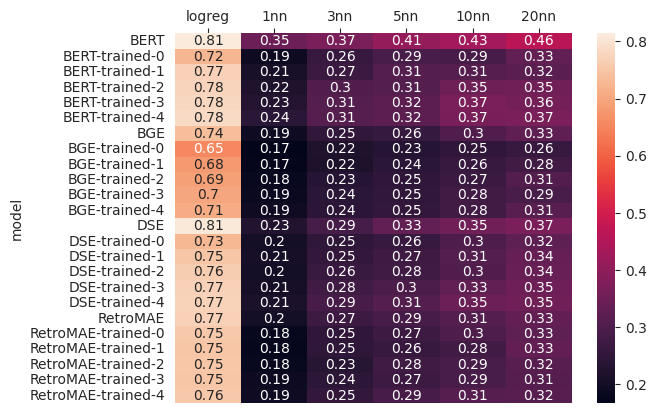

In [23]:
make_table('embedding')

In [33]:
def hidden_states(method, key_list=['embedding', 'hidden_state[-2]', 'hidden_state[-3]', 'hidden_state[-4]']):
    records = []
    for model in paths.keys():
        metrics = dict(model=model)
        for key in key_list:
            path = f'figures/{model}-{key}/aug-prediction'
            clf_report = json.load(open(f'{path}/all.json', 'r'))
            metrics[key] = clf_report[method]['accuracy']
        records.append(metrics)
    df = pd.DataFrame.from_records(records, index='model')
    plt.figure(figsize=(8,6))
    ax = sns.heatmap(df, annot=True)
    ax.xaxis.tick_top()
    plt.show()

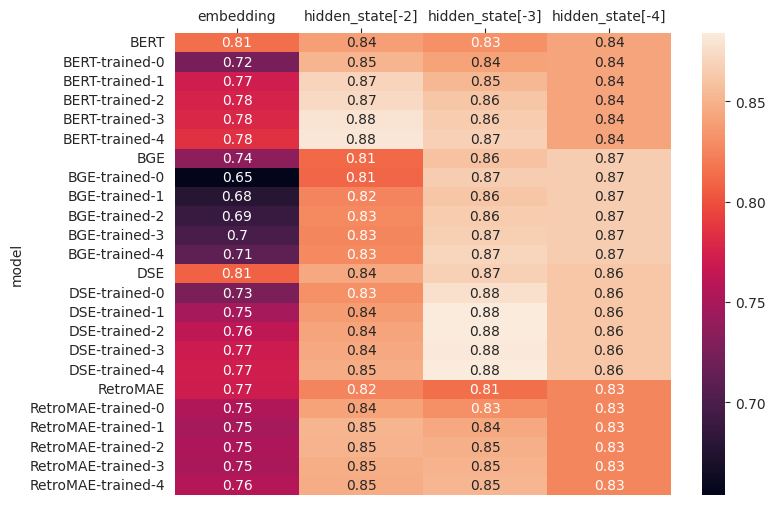

In [34]:
hidden_states('logreg')

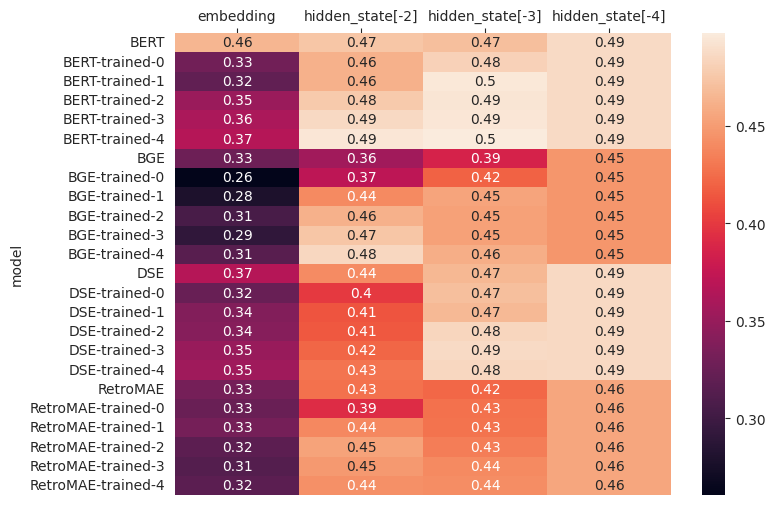

In [35]:
hidden_states('20nn')

In [55]:
def cosines(key, aug_list=['insert', 'replace', 'prune', 'shuffle']):
    records = []
    for model in paths.keys():
        classwise_cosines = []
        for aug in aug_list:
            path = f'figures/{model}-{key}/cosine/means'
            classwise_cosines.append(json.load(open(f'{path}/{aug}.json', 'r')))
        tmp = pd.DataFrame.from_records(classwise_cosines)
        record = tmp.mean(axis=0).to_dict()
        record['model'] = model
        records.append(record)
    df = pd.DataFrame.from_records(records, index='model')
    plt.figure(figsize=(12,6))
    ax = sns.heatmap(df, annot=True)
    ax.xaxis.tick_top()
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=90 )

    plt.show()

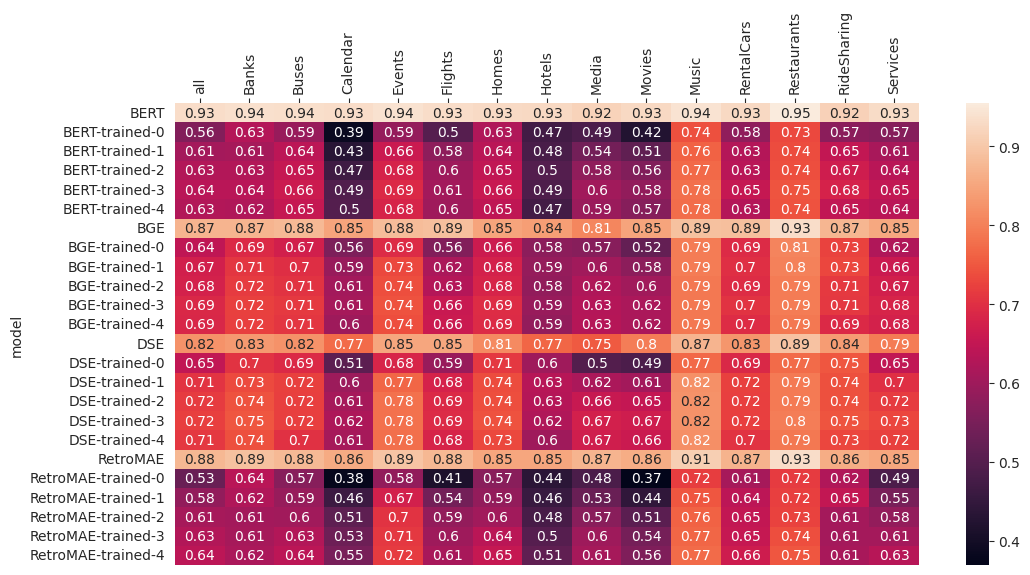

In [56]:
cosines('embedding')